In [1]:
using JuMP
import Ipopt
using StaticArrays, LinearAlgebra
using Plots
using Symbolics: Symbolics, @variables, scalarize
using Latexify
using BlockArrays: Block, BlockVector, mortar, blocksizes
using Ipopt
using SparseArrays
using CSV
using DataFrames
using Tables

In [27]:
function uni_dyna(x,u)
    return [x[1]+dt*u[1]*cos(x[3]), x[2]+dt*u[1]*sin(x[3]), x[3]+dt*u[2]]
end

function circleShape(h, k, r); gr()
    theta = LinRange(0, 2*pi, 500)
    h.+ r*sin.(theta), k.+ r*cos.(theta)
end

N = 100
n_x = 6
n_u = 4
state_dimension = 3
control_dimension = 2
horizon = 25
tf = 10.
dt = tf/(N)
u1_b = 0.15
u2_b = 0.75

xo = @SVector [10.0,0.0]
ro = 4.0
ra = 3.0

Q = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 5, 5, 2, 2])*0.6 # This is reference tracking and control cost
Qf = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 5, 5, 2, 2])*50
R = Diagonal(@SVector [10, 10, 5, 5])*0.8

noise_level = 1.0

full_traj = []

num_sim = 2

for sim in 1:num_sim

    x0 = [0,0,0,20,0.,pi] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]
    xf = [20,0.0,0,0,0.,pi] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    X_ref = hcat(collect(LinRange(x0[1],xf[1],N+1)), 
            collect(LinRange(x0[2],xf[2],N+1)),
            collect(LinRange(x0[3],xf[3],N+1)),
            collect(LinRange(x0[4],xf[4],N+1)), 
            collect(LinRange(x0[5],xf[5],N+1)),
            collect(LinRange(x0[6],xf[6],N+1)), zeros(N+1),zeros(N+1), zeros(N+1),zeros(N+1))

    problem_size = N*(n_x+n_u)

    X1_executed = zeros(N+1, 3)   # row 1 is start, row 2 after first step, … row N+1 after step N
    X2_executed = zeros(N+1, 3)
    U_executed  = zeros(N, 4)     # single control [u11,u12,u21,u22] at each step
    X1_executed[1, :] = x0[1:3]
    X2_executed[1, :] = x0[4:6]
    x1_curr = x0[1:3]
    x2_curr = x0[4:6]

    for k in 1:N
        # Compute the “true” last index without going out-of-bounds:
        start_idx = k
        end_idx   = min(k + horizon, size(X_ref, 1))   # size(X_ref,1) is the total number of rows

        # Extract whatever rows are available:
        X_ref_mpc = X_ref[start_idx:end_idx, :]
        segment  = X_ref[start_idx:end_idx, :]    # this is (num_rows × 10)
        num_rows = size(segment, 1)

        if num_rows < horizon + 1
            # Force last_row to be a 1×10 matrix, not a 10-element Vector:
            last_row = segment[num_rows:num_rows, :]   # or segment[end:end, :]

            miss = (horizon + 1) - num_rows            # how many rows we need to pad
            pad  = repeat(last_row, miss, 1)           # now pad is (miss × 10)

            X_ref_mpc = vcat(segment, pad)             # both have 10 columns
        else
            X_ref_mpc = segment                        # already (horizon+1) × 10
        end



        model = Model(Ipopt.Optimizer)

        @variable(model, x11[1:horizon+1])
        @variable(model, x12[1:horizon+1])
        @variable(model, x13[1:horizon+1])
        @variable(model, x21[1:horizon+1])
        @variable(model, x22[1:horizon+1])
        @variable(model, x23[1:horizon+1])

        @variable(model, 0<=u11[1:horizon+1] , start = 0)
        @variable(model, u12[1:horizon+1], start = 0);
        @variable(model, 0<=u21[1:horizon+1], start = 0)
        @variable(model, u22[1:horizon+1], start = 0);

        @variable(model, -u1_b <= du11[1:horizon+1] <= u1_b, start = 0)
        @variable(model, -u2_b <= du12[1:horizon+1] <= u2_b, start = 0);
        @variable(model, -u1_b <= du21[1:horizon+1] <= u1_b, start = 0)
        @variable(model, -u2_b <= du22[1:horizon+1] <= u2_b, start = 0);

        fix(x11[1],x1_curr[1],force=true)
        fix(x12[1],x1_curr[2],force=true)
        fix(x13[1],x1_curr[3],force=true)
        fix(x21[1],x2_curr[1],force=true)
        fix(x22[1],x2_curr[2],force=true)
        fix(x23[1],x2_curr[3],force=true)

        X_full = vcat(x11',x12',x13',x21',x22',x23',u11',u21',u12',u22')
        U_full = vcat(du11',du21',du12',du22')

        @objective(model, Min, tr((X_full'[1:horizon,:] - X_ref_mpc[1:horizon,:])*Q*(X_full[:,1:horizon] - X_ref_mpc'[:,1:horizon])) + tr(U_full'*R*U_full))

        @constraint(model, [t in 1:horizon], uni_dyna([x11[t],x12[t],x13[t]],[u11[t],u12[t]]) == [x11[t+1],x12[t+1],x13[t+1]]);
        @constraint(model, [t in 1:horizon], uni_dyna([x21[t],x22[t],x23[t]],[u21[t],u22[t]]) == [x21[t+1],x22[t+1],x23[t+1]]);
        @constraint(model, [t in 1:horizon], [u21[t]+du21[t+1],u22[t]+du22[t+1]] == [u21[t+1],u22[t+1]]);
        @constraint(model, [t in 1:horizon], [u11[t]+du11[t+1],u12[t]+du12[t+1]] == [u11[t+1],u12[t+1]]);
        @constraint(model, [t in 1:horizon+1], (x21[t] - x11[t])^2 + (x22[t] - x12[t])^2 - ra^2 >= 0);
        @constraint(model, [t in 1:horizon+1], (xo[1] - x11[t])^2 + (xo[2] - x12[t])^2 - ro^2 >= 0);
        @constraint(model, [t in 1:horizon+1], (xo[1] - x21[t])^2 + (xo[2] - x22[t])^2 - ro^2 >= 0);

        for i in 1:horizon+1
            set_start_value(x11[i],X_ref_mpc[i,1]+ 0.1*(2*rand()-1))
            set_start_value(x12[i],X_ref_mpc[i,2]+ 0.1*(2*rand()-1))
            set_start_value(x13[i],X_ref_mpc[i,3]+ 0.1*(2*rand()-1))
            set_start_value(x21[i],X_ref_mpc[i,4]+ 0.1*(2*rand()-1))
            set_start_value(x22[i],X_ref_mpc[i,5]+ 0.1*(2*rand()-1))
            set_start_value(x23[i],X_ref_mpc[i,6]+ 0.1*(2*rand()-1))

            set_start_value(u11[i],X_ref_mpc[i,7])
            set_start_value(u12[i],X_ref_mpc[i,8])
            set_start_value(u21[i],X_ref_mpc[i,9])
            set_start_value(u22[i],X_ref_mpc[i,10])

            set_start_value(du11[i],0.0)
            set_start_value(du12[i],0.0)
            set_start_value(du21[i],0.0)
            set_start_value(du22[i],0.0)
            
        end

        optimize!(model)

        @assert is_solved_and_feasible(model)

        u1_next = @SVector [ value(u11[1]), value(u12[1]) ]
        u2_next = @SVector [ value(u21[1]), value(u22[1]) ]
        nxt1 = uni_dyna(x1_curr, u1_next)
        nxt2 = uni_dyna(x2_curr, u2_next)
        X1_executed[k+1, :] = nxt1
        X2_executed[k+1, :] = nxt2
        U_executed[k, :]    = [u1_next[1], u1_next[2], u2_next[1], u2_next[2]]

        x1_curr = nxt1
        x2_curr = nxt2

        X1 = hcat(value.(x11),value.(x12),value.(x13))
        X2 = hcat(value.(x21),value.(x22),value.(x23))

        traj = hcat(value.(u11),value.(u12),value.(u21),value.(u22),
                    value.(x11),value.(x12),value.(x13), 
                    value.(x21),value.(x22),value.(x23))
    end

    if sim == 1
        plot(X1_executed[:,1], X1_executed[:,2], color=:blue, label="Agent 1")
        plot!(X2_executed[:,1], X2_executed[:,2], color=:orange, label="Agent 2")
        c1, c2 = circleShape(xo[1], xo[2], ro)
        plot!(c1, c2, seriestype=:shape, fillalpha=0.2, color=:gray, label="Obstacle")
        xlabel!("x"); ylabel!("y")
    end
end

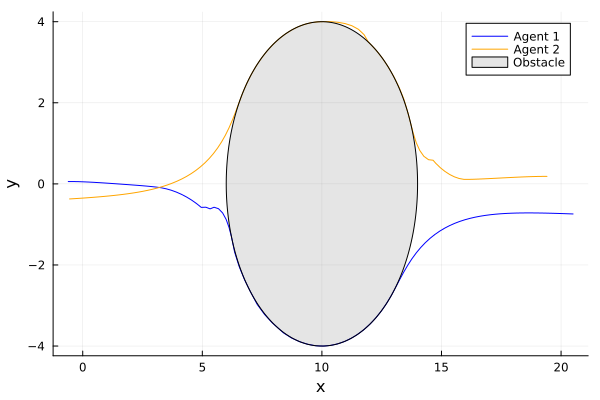

In [28]:
Plots.xlabel!("x")
Plots.ylabel!("y")

In [7]:
for i in 1:(size(full_traj)[2])
    println(maximum(full_traj[:,i]))
end

4.612369206615606
1.269209194669525
4.692649627544472
4.472568210126472
20.717985684492845
7.003708031789579
1.4074413785132767
20.99995003728337
7.0039000350925305
4.574391984781304


In [8]:
CSV.write("data/asym_trajs_noise1.csv",  Tables.table(full_traj), writeheader=false)

"data/asym_trajs_noise1.csv"

In [9]:
load_traj = Array(CSV.read("data/asym_trajs_noise1.csv",DataFrame,header=false);)

100000×10 Matrix{Float64}:
  2.10453      0.128088    2.16601      …  20.893      2.3922   3.14159
  2.10506      0.11035     2.16641         20.6764     2.3922   3.15247
  2.10568      0.0874879   2.16687         20.4598     2.38985  3.16162
  2.10622      0.0657492   2.16723         20.2432     2.38551  3.16851
  2.10663      0.0477695   2.16746         20.0265     2.37968  3.17319
  2.10692      0.0342509   2.16757      …  19.8099     2.37283  3.17598
  2.10713      0.0249552   2.16758         19.5933     2.36538  3.17725
  2.10728      0.0192648   2.16753         19.3766     2.35765  3.17733
  2.1074       0.0164814   2.16742         19.16       2.34991  3.17651
  2.10751      0.0159694   2.16728         18.9434     2.34234  3.175
  ⋮                                     ⋱                       
  1.2          0.00477793  1.2              0.2858     1.53201  3.14775
  1.05         0.00483365  1.05             0.165803   1.53127  3.14718
  0.9          0.00534145  0.9              0.

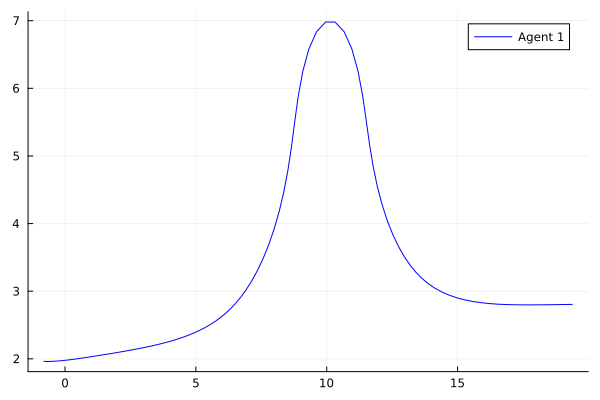

In [14]:
traj = load_traj[101:200, :]  # select rows 1 to 100, and all columns
Plots.plot(traj[:,5],traj[:,6],color="blue",label="Agent 1")
# Plots.plot(traj[:,4],traj[:,5],color="orange",label="Agent 2")

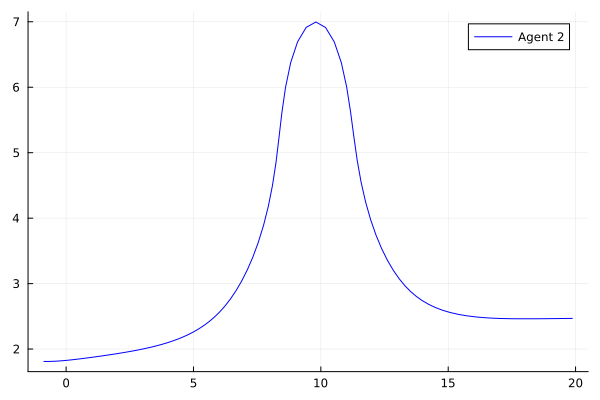

In [ ]:
traj2 = load_traj[1:100, :]  # select rows 1 to 100, and all columns
Plots.plot(traj[:,5],traj[:,6],color="blue",label="Agent 1")
